# A biophysical spiking network model: MINST all digits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

# config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import sys
os.chdir('/teamspace/studios/this_studio/nblauch/jaxley_experiments/nex/fig6_mnist/notebooks')


In [3]:
ls

01_forward_passes.ipynb*   03_assemble_figure_2.ipynb*
03_assemble_figure.ipynb*  04_supp_figure_tuning.ipynb*


In [4]:
import jax.numpy as jnp

In [5]:
from itertools import chain
import pickle
import time

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
from jax.scipy.special import logsumexp

import optax
# import tensorflow as tf
# import tensorflow_datasets as tfds
from jax.nn import sigmoid

import jaxley as jx
from jaxley.channels import HH
from jaxley.channels import CaL, CaT, K, Km, Leak, Na
from jaxley.synapses import IonotropicSynapse, TanhRateSynapse
# from jaxley_mech.synapses import AMPA, NMDA, GABAa, GABAb
from jaxley.optimize.utils import l2_norm
from jaxley.connect import fully_connect, connect, sparse_connect

In [7]:
dales_law = False
comp_length = 40

i_amp_factor = comp_length / 10 

scale_readout_receptive_strength = 10

soma_radius = 10
soma_length = 2 * soma_radius

In [8]:
dt = 0.025
t_max = 10.01
time_vec = np.arange(0, t_max+2*dt, dt)
levels = 3
checkpoints = [int(np.ceil(len(time_vec)**(1/levels))) for _ in range(levels)]

i_delay = 0.1
i_dur = 1.0
# voltages.shape[1] - 10
cols = [
    "#f0f0f0",
    "#d9d9d9",
    "#bdbdbd",
    "#969696",
    "#737373",
    "#525252",
    "#252525",
    "#000000",
]

### Load training data

In [9]:
from torchvision.datasets import MNIST

train = MNIST(root='~/data', train=True, download=True)
test = MNIST(root='~/data', train=False, download=True)


In [10]:
# Jaxley specific
pos_voltage = -90.0
neg_voltage = -50.0

def image_voltage_label(dataset):
    
    train_images = np.reshape(np.squeeze(dataset.data), (-1, 28**2)) / 255.0
    train_labels = dataset.targets
    
    # Cast to JAX
    train_images = jnp.asarray(train_images)
    train_labels = jnp.asarray(train_labels)

    return train_images, train_labels

train_images, train_labels = image_voltage_label(train)
test_images, test_labels = image_voltage_label(test)

2024-10-22 19:36:22.681351: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Build network

In [11]:
# fnames = os.listdir("../morphologies/")
# fnames = [f for f in fnames if f.startswith("n")]
# fnames = [f"../morphologies/{f}/{f}.CNG.swc" for f in fnames]

In [12]:
nseg = 4  # original: 4

comp = jx.Compartment()
branch = jx.Branch(comp, nseg)
input_cell = jx.Cell(branch, [-1])

# Dendrites.
input_cell[0, 1:nseg].set("length", comp_length)
input_cell[0, 1:nseg].set("radius", 1.0)

input_cell[0, 0].set("length", soma_length)
input_cell[0, 0].set("radius", soma_radius)

input_neurons = [input_cell for _ in range(28**2)]

# morph_cells = [jx.read_swc(fname, nseg=4, assign_groups=True) for fname in fnames]
# morph_cells = [jx.read_swc(fname, nseg=2) for fname in fnames]
morph_cells = [jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]) for _ in range(64)]

# hidden_cell = jx.Cell(branch, [-1, 0, 0])
hidden_neurons = [morph_cells[i % len(morph_cells)] for i in range(64)]

output_cell = jx.Cell(branch, [-1])

output_cell[0, 1:nseg].set("length", comp_length)
output_cell[0, 1:nseg].set("radius", 1.0)

output_cell[0, 0].set("length", soma_length)
output_cell[0, 0].set("radius", soma_radius)

output_neurons = [output_cell for _ in range(10)]

all_neurons = input_neurons + hidden_neurons + output_neurons
net = jx.Network(all_neurons)


In [13]:
os.makedirs("../results", exist_ok=True)
with open("../results/01_network.pkl", "wb") as handle:
    pickle.dump(net, handle)

### Define layers of cells and split into exc and inh

In [14]:
def get_non_selected_indices(a, b, selected_indices):
    all_indices = np.arange(a, b)
    non_selected_indices = np.setdiff1d(all_indices, selected_indices)
    return non_selected_indices

In [15]:
_ = np.random.seed(4)

layer_inds = [0, 28**2, 28**2 + 64]  # , 28**2 + 64 + 2]

exc_frac = 0.75

for layer in range(len(layer_inds) - 1):
    num = layer_inds[layer + 1] - layer_inds[layer]
    a = layer_inds[layer]
    b = layer_inds[layer+1]
    exc_neuron_inds = np.random.choice(np.arange(a, b), (int(num * exc_frac)), replace=False)
    inh_neuron_inds = get_non_selected_indices(a, b, exc_neuron_inds)

    net.cell(exc_neuron_inds.tolist()).add_to_group(f"layer{layer}_exc")
    net.cell(inh_neuron_inds.tolist()).add_to_group(f"layer{layer}_inh")

net.cell(np.arange(28**2).tolist()).add_to_group("layer0")
net.cell(np.arange(28**2, 28**2+64).tolist()).add_to_group("layer1")
net.cell(np.arange(28**2+64, 28**2+64+10).tolist()).add_to_group("layer2")

### Insert cellular mechanisms

In [16]:
net.layer0.insert(HH())
net.layer1.insert(HH())
net.layer2.insert(Leak())
net.set("axial_resistivity", 100.0)

### Insert synapses

In [17]:
_ = np.random.seed(5)

pre = net.layer0_exc.cell("all")
post = net.layer1.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns1_exc"))

pre = net.layer0_inh.cell("all")
post = net.layer1.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns1_inh"))

pre = net.layer1_exc.cell("all")
post = net.layer2.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns2_exc"))

pre = net.layer1_inh.cell("all")
post = net.layer2.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns2_inh"))

In [18]:
_ = np.random.seed(0) #2)  # 2, 8

if dales_law:
    w1_exc = np.abs(np.random.randn(len(net.Conns1_exc.view)) / 28**2)
    w1_inh = np.abs(np.random.randn(len(net.Conns1_inh.view)) / 28**2)
    w2_exc = np.abs(np.random.randn(len(net.Conns2_exc.view)) / 64)
    w2_inh = np.abs(np.random.randn(len(net.Conns2_inh.view)) / 64)
    
    # Weaker synapses in the second layer (because we project on non-spiking neurons)
    w1_exc /= 25.0
    w1_inh /= 25.0
    w2_exc /= 2_500.0
    w2_inh /= 2_500.0
    
    # Inhibitory synapses should be stronger.
    w1_exc *= 1.0
    w1_inh *= 5.0
    w2_exc *= 1.0 * i_amp_factor
    w2_inh *= 5.0 * i_amp_factor
    
    net.Conns1_exc("all").set("Conns1_exc_gS", w1_exc)
    net.Conns1_inh("all").set("Conns1_inh_gS", w1_inh)
    net.Conns2_exc("all").set("Conns2_exc_gS", w2_exc)
    net.Conns2_inh("all").set("Conns2_inh_gS", w2_inh)
    
    e_syn_exc = 0.0
    e_syn_inh = -100.0
    net.Conns1_exc("all").set("Conns1_exc_e_syn", e_syn_exc)
    net.Conns1_inh("all").set("Conns1_inh_e_syn", e_syn_inh)
    net.Conns2_exc("all").set("Conns2_exc_e_syn", e_syn_exc)
    net.Conns2_inh("all").set("Conns2_inh_e_syn", e_syn_inh)
else:
    w1_exc = np.random.randn(len(net.Conns1_exc.view)) / 28**2
    w1_inh = np.random.randn(len(net.Conns1_inh.view)) / 28**2
    w2_exc = np.random.randn(len(net.Conns2_exc.view)) / 64
    w2_inh = np.random.randn(len(net.Conns2_inh.view)) / 64
    
    # Weaker synapses in the second layer (because we project on non-spiking neurons)
    w1_exc /= 25.0
    w1_inh /= 25.0
    w2_exc /= 25.0
    w2_inh /= 25.0
    
    # Inhibitory synapses should be stronger.
    w1_exc *= 1.0
    w1_inh *= 1.0
    w2_exc *= 1.0 * i_amp_factor / scale_readout_receptive_strength
    w2_inh *= 1.0 * i_amp_factor / scale_readout_receptive_strength
    
    net.Conns1_exc("all").set("Conns1_exc_gS", w1_exc)
    net.Conns1_inh("all").set("Conns1_inh_gS", w1_inh)
    net.Conns2_exc("all").set("Conns2_exc_gS", w2_exc)
    net.Conns2_inh("all").set("Conns2_inh_gS", w2_inh)

    
net.Conns1_exc("all").set("Conns1_exc_k_minus", 0.25)
net.Conns1_inh("all").set("Conns1_inh_k_minus", 0.25)
net.Conns2_exc("all").set("Conns2_exc_k_minus", 0.25)
net.Conns2_inh("all").set("Conns2_inh_k_minus", 0.25)

### Define simulation and loss

In [47]:
tau = 500.0
i_amp = i_amp_factor * 50.0 / tau

def simulate(params, image):
    currents = jx.datapoint_to_step_currents(i_delay, i_dur, i_amp*image, dt, t_max)
    data_stimuli = net[range(784), 0, nseg-1].data_stimulate(currents, None)
    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

def simulate_currents(params, image):
    currents = jx.datapoint_to_step_currents(i_delay, i_dur, i_amp*image, dt, t_max)
    return currents

jitted_simulate = jit(simulate)
vmapped_simulate = jit(vmap(simulate, in_axes=(None, 0)))

jitted_simulate_currents = jit(simulate_currents)
vmapped_simulate_currents = jit(vmap(simulate_currents, in_axes=(None, 0)))


In [20]:
def predict(params, image):
    vs = simulate(params, image)
    return vs[:, -1]

vmapped_predict = jit(vmap(predict, in_axes=(None, 0)))

In [21]:
def cross_entropy_loss(opt_params, image, label):
    params = transform.forward(opt_params)
    prediction = predict(params, image)
    prediction += 65.0
    prediction /= 3.0
    log_prob = prediction[label] - logsumexp(prediction)
    return -log_prob

vmapped_cross_entropy_loss = jit(vmap(cross_entropy_loss, in_axes=(None, 0, 0)))

In [22]:
def batch_loss(opt_params, image_batch, label_batch):
    losses = vmap(cross_entropy_loss, in_axes=(None, 0, 0))(opt_params, image_batch, label_batch)
    return jnp.mean(losses)

jitted_batch_loss = jit(batch_loss)
loss_grad = jit(value_and_grad(batch_loss, argnums=0))

In [23]:
def eval_cross_entropy_accuracy(opt_params, num_eval: int, train_or_test: str, start_ind: int = 0):
    if train_or_test == "train":
        images = train_images[start_ind:start_ind+num_eval]
        labels = train_labels[start_ind:start_ind+num_eval]
    elif train_or_test == "test":
        images = test_images[start_ind:start_ind+num_eval]
        labels = test_labels[start_ind:start_ind+num_eval]
    else:
        raise ValueError
    
    prediction = vmapped_predict(
        transform.forward(opt_params),
        images,
    )[:, -10:]
    prediction = jnp.argmax(prediction, axis=1).astype(int)
    return np.mean(prediction == labels)

In [24]:
safety_magin = 5.0

if dales_law:
    transform = jx.ParamTransform(
        lowers={
            "Conns1_exc_gS": 0.0, 
            "Conns1_inh_gS": 0.0, 
            "Conns2_exc_gS": 0.0, 
            "Conns2_inh_gS": 0.0, 
            "HH_gNa": 0.05, 
            "HH_gK": 0.01, 
            "HH_gLeak": 0.0001,
            "axial_resistivity": 30.0,
        },
        uppers={
            "Conns1_exc_gS": safety_magin / 28**2 / 25.0,
            "Conns1_inh_gS": safety_magin / 28**2 / 25.0 * 5.0,
            "Conns2_exc_gS": safety_magin / 64.0 / 2_500.0 * i_amp_factor,
            "Conns2_inh_gS": safety_magin / 64.0 / 2_500.0 * 5.0 * i_amp_factor,
            "HH_gNa": 0.5,
            "HH_gK": 0.1,
            "HH_gLeak": 0.001,
            "axial_resistivity": 1_000,
        },
    )
else:
    transform = jx.ParamTransform(
        lowers={
            "Conns1_exc_gS": -safety_magin / 28**2 / 25.0,
            "Conns1_inh_gS": -safety_magin / 28**2 / 25.0 ,
            "Conns2_exc_gS": -safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "Conns2_inh_gS": -safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "HH_gNa": 0.05, 
            "HH_gK": 0.01, 
            "HH_gLeak": 0.0001,
            "axial_resistivity": 30.0,
        },
        uppers={
            "Conns1_exc_gS": safety_magin / 28**2 / 25.0,
            "Conns1_inh_gS": safety_magin / 28**2 / 25.0 ,
            "Conns2_exc_gS": safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "Conns2_inh_gS": safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "HH_gNa": 0.5,
            "HH_gK": 0.1,
            "HH_gLeak": 0.001,
            "axial_resistivity": 1_000,
        },
    )

### Train

In [25]:
net.set("v", -65)
net.init_states()

In [26]:
net.delete_trainables()
net.Conns1_exc("all").make_trainable("Conns1_exc_gS")
net.Conns1_inh("all").make_trainable("Conns1_inh_gS")
net.Conns2_exc("all").make_trainable("Conns2_exc_gS")
net.Conns2_inh("all").make_trainable("Conns2_inh_gS")
net.cell("all").branch("all").make_trainable("HH_gNa")
net.cell("all").branch("all").make_trainable("HH_gK")
net.cell("all").branch("all").make_trainable("HH_gLeak")
net.cell("all").branch("all").make_trainable("axial_resistivity")
initial_parameters = net.get_parameters()

Number of newly added trainable parameters: 37632. Total number of trainable parameters: 37632
Number of newly added trainable parameters: 12544. Total number of trainable parameters: 50176
Number of newly added trainable parameters: 480. Total number of trainable parameters: 50656
Number of newly added trainable parameters: 160. Total number of trainable parameters: 50816
Number of newly added trainable parameters: 1744. Total number of trainable parameters: 52560
Number of newly added trainable parameters: 1744. Total number of trainable parameters: 54304
Number of newly added trainable parameters: 1744. Total number of trainable parameters: 56048
Number of newly added trainable parameters: 1754. Total number of trainable parameters: 57802


In [27]:
initial_opt_params = transform.inverse(initial_parameters)
with open("../results/initial_parameters", "wb") as handle:
    pickle.dump(initial_parameters, handle)

In [28]:
# with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
#     opt_params = pickle.load(handle)

opt_params = initial_opt_params

parameters = transform.forward(opt_params)
# with open("../../../nex/ca1net/results/parameters/MichaelRun/parameters_1770", "wb") as handle:
#     pickle.dump(parameters, handle)

In [29]:
# with open("results/parameters/TrainingRun_0010/chkpts/005/parameters_0900", "wb") as handle:
#     pickle.dump(parameters, handle)

In [30]:
# net.delete_recordings()
# net.delete_stimuli()
# net[:, :, :].record()

# images = test_images[6:7]
# labels = test_labels[6:7]
# voltages = vmapped_simulate(parameters, images)
# print("Time: ", time.time() - start_time)
# with open("../../paper/fig6_mnist/results/traces/v_all_compartments.pkl", "wb") as handle:
#     pickle.dump(voltages, handle)


In [31]:
net.delete_recordings()
net.delete_stimuli()
net[:, 0, 0].record()

Added 858 recordings. See `.recordings` for details.


In [48]:
# all_voltages = []
# all_labels = []
# all_images = []
# batchsize = 128
# for k in range(1):
#     images = test_images[k*batchsize:(k+1)*batchsize]
#     labels = test_labels[k*batchsize:(k+1)*batchsize]
#     start_time = time.time()
#     voltages = vmapped_simulate(parameters, images)
#     print("Time: ", time.time() - start_time)
#     all_voltages.append(voltages)
#     all_labels.append(labels)
#     all_images.append(images)

all_voltages = []
all_labels = []
all_images = []
batchsize = 128
for k in range(1):
    images = test_images[k*batchsize:(k+1)*batchsize]
    labels = test_labels[k*batchsize:(k+1)*batchsize]
    start_time = time.time()
    voltages = vmapped_simulate_currents(parameters, images)
    print("Time: ", time.time() - start_time)
    # all_voltages.append(voltages)
    # all_labels.append(labels)
    # all_images.append(images



    

Time:  0.08439111709594727


In [56]:
voltages[0].argmax(0)

Array([  0,   0,   0,   0, 355, 355, 355, 355, 355, 355, 355, 355, 355,
       355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355,
       355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355,
       355, 355, 355, 355, 355,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

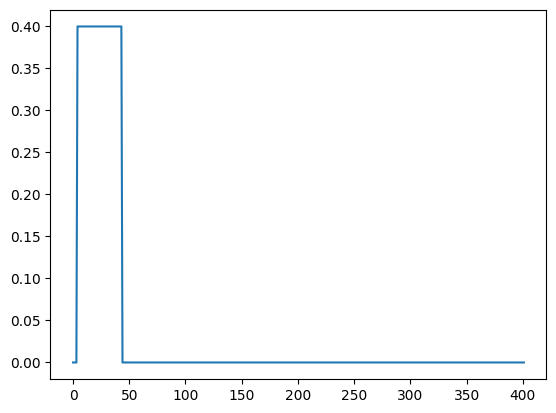

In [57]:
plt.plot(voltages[0, 355,:])

In [59]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/zeus/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [95]:
from torch.utils.data import DataLoader
import torch
from torch import nn

class HeadLessAlexNet(torch.nn.Module):
    def __init__(self, alexnet):
        super().__init__()
        self.features = alexnet.features
        self.classifier = alexnet.classifier
        self.projector = nn.Linear(9216, 784)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.projector(x)
        return x


In [105]:
alexnet_headless = HeadLessAlexNet(alexnet)
alexnet_headless.eval()

alexnet_outputs = alexnet_headless(torch.tensor(images))
alexnet_outputs = alexnet_outputs.detach().numpy()


/tmp/ipykernel_30872/896766498.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alexnet_outputs = alexnet_headless(torch.tensor(images))


In [34]:
all_voltages = np.concatenate(all_voltages, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_images = np.concatenate(all_images, axis=0)

In [104]:
from torch.utils.data import DataLoader
import torchvision

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    ])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)


loader = DataLoader(train_dataset, batch_size=batchsize)

batch = next(iter(loader))
images, labels = batch

# make images have 3 channel
images = images.repeat(1,3, 1, 1)

alexnet_outputs = alexnet_headless(images)
alexnet_outputs = alexnet_outputs.detach().numpy()


In [94]:
train_images.shape

(60000, 784)

In [106]:
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batchsize)

all_voltages = []
all_labels = []
all_images = []
batchsize = 128
max_batches = 1
for ii, batch in enumerate(test_loader):
    images, labels = batch
    # make images have 3 channel
    images = images.repeat(1,3, 1, 1)
    start_time = time.time()
    alexnet_outputs = alexnet_headless(images)
    alexnet_outputs = alexnet_outputs.detach().numpy()
    voltages = vmapped_simulate(parameters, alexnet_outputs)
    if ii >= max_batches-1:
        break


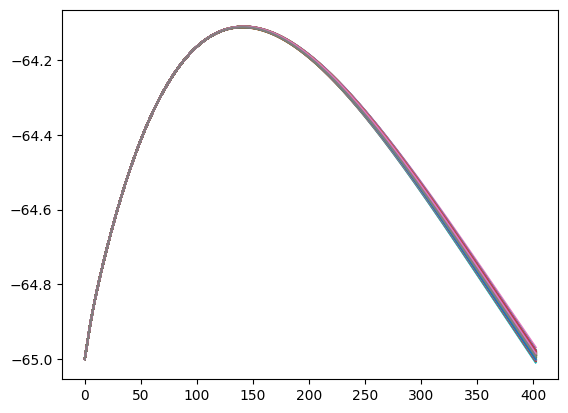

In [111]:
plt.plot(voltages[:,0].transpose())
plt.show()

### Save outputs of a subset of neurons but all images (for correlation plots)

In [35]:
os.makedirs("../results/traces", exist_ok=True)

with open("../results/traces/output_trained.pkl", "wb") as handle:
    pickle.dump(all_voltages[:, 28**2:], handle)

with open("../results/traces/labels_trained.pkl", "wb") as handle:
    pickle.dump(all_labels, handle)


### Save all neuron outputs of a few images (for trace visualization)

In [36]:
os.makedirs("../results/traces", exist_ok=True)
with open("../results/traces/output_trained_all_neurons_few_images.pkl", "wb") as handle:
    pickle.dump(all_voltages[:50], handle)

In [37]:
with open("../results/traces/images_trained.pkl", "wb") as handle:
    pickle.dump(all_images, handle)

# Adversarial example

In [38]:
net.delete_recordings()
net.delete_stimuli()
net[range(28**2+64, 28**2+64+10), 0, 0].record()

Added 10 recordings. See `.recordings` for details.


In [39]:
from copy import deepcopy


vmapped_simulate = jit(vmap(simulate, in_axes=(None, 0)))

def tf_image(image):
    image = sigmoid(image)
    return image

def predict(params, image):
    image = tf_image(image)
    v = simulate(params, image)
    return v[:, -1]

vmapped_predict = jit(vmap(predict, in_axes=(None, 0)))


def target_neg_logprob(prediction, target_class):
    prediction += 65.0
    prediction /= 3.0
    log_prob = prediction[target_class] - logsumexp(prediction)
    return -log_prob


def adv_example_loss(params, image, regularization_lambda, target_class, baseline):
    class_loss = target_neg_logprob(predict(params, image), target_class)
    reg_loss = jnp.abs(jnp.sum(image) - baseline)
    return class_loss + regularization_lambda * reg_loss

image_loss_grad = jit(value_and_grad(adv_example_loss, argnums=(1,)))
images_loss_grads = jit(vmap(value_and_grad(adv_example_loss, argnums=(1,)), in_axes=(None, 0, None, 0, None)))

In [40]:
def optimize_attack(
    init: jnp.ndarray,
    target_class: int,
    epochs: int = 10,
    lr: float = 2.0,
    momentum: float = 0.0,
    regularization_lambda: float = 0.0,
):
    mei = init
    optimizer = optax.sgd(learning_rate=lr, momentum=momentum)
    opt_state = optimizer.init(mei)
    losses = []
    travelled_distance = np.asarray([0.0 for _ in range(len(init))])
    travelled_distances = [deepcopy(travelled_distance)]
    predictions_at_every_step = []
    previous_image = mei
    all_accuracies = []
    all_images = []
    all_traces = []

    for epoch in range(epochs):
        loss_val, gradient_val = images_loss_grads(
            parameters,
            mei,
            regularization_lambda,
            target_class,
            jnp.asarray(200.0),
        )
        losses.append(loss_val)
        act = vmapped_predict(parameters, mei)
        predictions_at_every_step.append(deepcopy(act))
        trace = vmapped_simulate(parameters, mei)
        all_traces.append(deepcopy(trace[:, -10:, :]))
        # print(f"Epoch {epoch}, loss_val {loss_val}, predicted_voltages {act} argmax {np.argmax(act, axis=1)}")
        label_predictions = np.argmax(act, axis=1)
        # print(f"Epoch {epoch}, loss_val {loss_val} argmax {label_predictions}")
        current_accuracy = np.mean(label_predictions == initial_labels)
        print(f"Accuracy {current_accuracy}")
        all_accuracies.append(deepcopy(current_accuracy))
    
        gradient_corr = (gradient_val[0].T / jnp.sqrt(jnp.sum(gradient_val[0]**2, axis=1))).T
        updates, opt_state = optimizer.update(gradient_corr, opt_state)
        mei = optax.apply_updates(mei, updates)

        travelled_distance += np.sqrt(np.sum((mei - previous_image)**2, axis=1))
        travelled_distances.append(deepcopy(travelled_distance))
        previous_image = mei
        all_images.append(deepcopy(mei))
        # print(f"travelled_distances {travelled_distances}")

    act = vmapped_predict(parameters, mei)
    predictions_at_every_step.append(deepcopy(act))

    vs = vmapped_simulate(parameters, tf_image(mei))
    return mei, losses, vs, travelled_distances, predictions_at_every_step, all_accuracies, all_images, all_traces


In [41]:
lr = 5.0

os.makedirs("../results/attacks", exist_ok=True)

for seed in range(1, 9):
    _ = np.random.seed(seed)
    
    n = 16
    n_candidates = int(n * 1.5)
    indices = np.arange((seed-1) * n_candidates, seed * n_candidates)
    initial_labels = train_labels[indices]
    
    target_labels = np.random.randint(0, 10, n_candidates)
    condition = target_labels != initial_labels
    
    initial_indices = indices[condition][:n]
    initial_labels = initial_labels[condition][:n]
    targets = target_labels[condition][:n]
    meis = train_images[initial_indices]
    
    meis = meis.at[meis == 0.0].add(0.01)
    meis = meis.at[meis == 1.0].add(-0.01)
    meis = jnp.log(meis / (1 - meis))  # logit to make mei unconstrained.
    print(f"Initial labels {initial_labels}")
    print(f"Target labels  {targets}")
    
    vs_init = vmapped_simulate(parameters, tf_image(meis))
    
    with open(f"../results/attacks/attack_image_before_seed{seed}.pkl", "wb") as handle:
        pickle.dump(meis, handle)
    with open(f"../results/attacks/attack_trace_before_seed{seed}.pkl", "wb") as handle:
        pickle.dump(vs_init, handle)
    
    mei_opt, losses, vs, travelled, predictions, all_accuracies, all_images, all_traces = optimize_attack(
        meis,
        target_class=targets,
        epochs=30,
        lr=lr,
        momentum=0.0,
        regularization_lambda=0.0,
    )
    with open(f"../results/attacks/attack_image_after_seed{seed}.pkl", "wb") as handle:
        pickle.dump(mei_opt, handle)
    with open(f"../results/attacks/attack_trace_after_seed{seed}.pkl", "wb") as handle:
        pickle.dump(vs, handle)
    with open(f"../results/attacks/attack_losses_seed{seed}.pkl", "wb") as handle:
        pickle.dump(losses, handle)
    with open(f"../results/attacks/travelled_seed{seed}.pkl", "wb") as handle:
        pickle.dump(travelled, handle)
    with open(f"../results/attacks/predictions_seed{seed}.pkl", "wb") as handle:
        pickle.dump(predictions, handle)
    with open(f"../results/attacks/all_accuracies_seed{seed}.pkl", "wb") as handle:
        pickle.dump(all_accuracies, handle)
    with open(f"../results/attacks/all_images_seed{seed}.pkl", "wb") as handle:
        pickle.dump(all_images, handle)
    with open(f"../results/attacks/all_traces_seed{seed}.pkl", "wb") as handle:
        pickle.dump(all_traces, handle)
    with open(f"../results/attacks/initial_labels_seed{seed}.pkl", "wb") as handle:
        pickle.dump(initial_labels, handle)
    with open(f"../results/attacks/target_labels_seed{seed}.pkl", "wb") as handle:
        pickle.dump(targets, handle)

Initial labels [0 4 1 9 2 3 1 4 3 5 3 6 1 7 2 8]
Target labels  [8 9 5 0 0 7 6 9 2 4 5 2 4 2 4 7]


KeyboardInterrupt: 

# Performance evaluation

### With all parameters trained

In [42]:
net.delete_recordings()
net.delete_stimuli()
net[range(28**2+64, 28**2+64+10), 0, 0].record()

Added 10 recordings. See `.recordings` for details.


In [43]:
accuracies = {}

In [44]:
all_accs = []
for i in range(10):
    test_acc = eval_cross_entropy_accuracy(opt_params, 1000, "test", 1000*i)
    all_accs.append(test_acc)
    print(f"{i} Test accuracy full {test_acc}")
all_accs = np.asarray(all_accs)
print("all_accs", all_accs, "mean", np.mean(all_accs))

0 Test accuracy full 0.11600000411272049
1 Test accuracy full 0.10300000756978989
2 Test accuracy full 0.09400000423192978
3 Test accuracy full 0.10500000417232513


KeyboardInterrupt: 

In [42]:
all_accs = []
for i in range(9):
    test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test", 1024*i)
    all_accs.append(test_acc)
    print(f"{i} Test accuracy full {test_acc}")
all_accs = np.asarray(all_accs)
print("all_accs", all_accs, "mean", np.mean(all_accs))

0 Test accuracy full 0.958984375
1 Test accuracy full 0.9287109375
2 Test accuracy full 0.9326171875
3 Test accuracy full 0.94140625
4 Test accuracy full 0.9423828125
5 Test accuracy full 0.9453125
6 Test accuracy full 0.9541015625
7 Test accuracy full 0.9560546875
8 Test accuracy full 0.943359375
all_accs [0.9589844  0.92871094 0.9326172  0.94140625 0.9423828  0.9453125
 0.95410156 0.9560547  0.9433594 ] mean 0.94477


In [43]:
for i in range(9):
    test_acc = eval_cross_entropy_accuracy(opt_params, 700, "test", 1024*9)
    print(f"{i} Test accuracy full {test_acc}")

AttributeError: 'numpy.ndarray' object has no attribute 'append'

### Return to old

In [43]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test", 0)
print(f"Test accuracy full {test_acc}")
accuracies["all"] = test_acc

Test accuracy full 0.9521484375


In [44]:
net.delete_trainables()
net.Conns1_exc("all").make_trainable("Conns1_exc_gS")
net.Conns1_inh("all").make_trainable("Conns1_inh_gS")
net.Conns2_exc("all").make_trainable("Conns2_exc_gS")
net.Conns2_inh("all").make_trainable("Conns2_inh_gS")
net.cell("all").branch("all").make_trainable("HH_gNa")
net.cell("all").branch("all").make_trainable("HH_gK")
net.cell("all").branch("all").make_trainable("HH_gLeak")
net.cell("all").branch("all").make_trainable("axial_resistivity")
initial_parameters = net.get_parameters()
initial_parameters = transform.inverse(initial_parameters)

Number of newly added trainable parameters: 37632. Total number of trainable parameters: 37632
Number of newly added trainable parameters: 12544. Total number of trainable parameters: 50176
Number of newly added trainable parameters: 480. Total number of trainable parameters: 50656
Number of newly added trainable parameters: 160. Total number of trainable parameters: 50816
Number of newly added trainable parameters: 13938. Total number of trainable parameters: 64754
Number of newly added trainable parameters: 13938. Total number of trainable parameters: 78692
Number of newly added trainable parameters: 13938. Total number of trainable parameters: 92630
Number of newly added trainable parameters: 13948. Total number of trainable parameters: 106578


### With all first layer synapses reset to baseline

In [47]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

for i in range(2):
    opt_params[i] = initial_parameters[i]

In [48]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Test accuracy full {test_acc}")
accuracies["no_first_layer"] = test_acc

Test accuracy full 0.14453125


### With all second layer synapses reset to baseline

In [49]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

for i in range(2, 4):
    opt_params[i] = initial_parameters[i]

In [50]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Test accuracy full {test_acc}")
accuracies["no_second_layer"] = test_acc

Test accuracy full 0.3349609375


### With sodium reset to baseline

In [51]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

for i in range(4, 5):
    opt_params[i] = initial_parameters[i]

In [52]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Test accuracy full {test_acc}")
accuracies["no_sodium"] = test_acc

Test accuracy full 0.64453125


### With potassium reset to baseline

In [53]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

for i in range(5, 6):
    opt_params[i] = initial_parameters[i]

In [54]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Test accuracy full {test_acc}")
accuracies["no_potassium"] = test_acc

Test accuracy full 0.5859375


### With leak reset to baseline

In [55]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

for i in range(6, 7):
    opt_params[i] = initial_parameters[i]

In [56]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Test accuracy full {test_acc}")
accuracies["no_leak"] = test_acc

Test accuracy full 0.9150390625


### With all channels reset to baseline

In [57]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

for i in range(4, 7):
    opt_params[i] = initial_parameters[i]

In [58]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Test accuracy full {test_acc}")
accuracies["no_channels"] = test_acc

Test accuracy full 0.4794921875


### With all axial resistivities reset to baseline

In [59]:
with open("../../../nex/ca1net/results/parameters/MichaelRun/opt_params_1770", "rb") as handle:
    opt_params = pickle.load(handle)

for i in range(7, 8):
    opt_params[i] = initial_parameters[i]

In [60]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Test accuracy full {test_acc}")
accuracies["no_axial_resistivities"] = test_acc

Test accuracy full 0.91796875


In [61]:
accuracies

{'all': Array(0.95214844, dtype=float32),
 'no_first_layer': Array(0.14453125, dtype=float32),
 'no_second_layer': Array(0.33496094, dtype=float32),
 'no_sodium': Array(0.64453125, dtype=float32),
 'no_potassium': Array(0.5859375, dtype=float32),
 'no_leak': Array(0.91503906, dtype=float32),
 'no_channels': Array(0.4794922, dtype=float32),
 'no_axial_resistivities': Array(0.91796875, dtype=float32)}

In [63]:
with open("../results/accuracies/dropout_accuracies.pkl", "wb") as handle:
    pickle.dump(accuracies, handle)